## 3주차 진행상황 요약

---
1. **Feature Extraction**
    * **reordered** 항목에 대한 분석을 중점으로 두었습니다. priors에 orders와 products를 병합하여 마지막 주문 정보들이 사라지고 구매내역이 있는 제품의 정보만 남게하였습니다. 대부분의 컬럼들에 대해 평균과 표준편차 컬럼을 추가하였고, 유저의 n번째 주문들을 분석하여 패턴을 파악하였습니다.

2. **Data Preparation**
    * train에 orders를 병합하여 마지막 주문을 추가하였습니다. 마지막 주문에 처음 주문된 제품은 다른 컬럼들이 모두 결측치이기때문에 평균값으로 채워주고, 마지막 주문에 주문하지 않은 제품은 결측치를 0으로 채웠습니다. 제품별 마지막 주문과 총 주문의 차이 피처를 추가했습니다.

3. **Models**
    * 세가지 모델로 스코어를 테스트 해보았습니다.

|model|f1 score|
|---|:---:|
|LGBM|0.2918|
|XGBoost|0.3684|
|Catboost|0.4415|

# 1. Feature Extraction

참조 : https://github.com/GyeongHwanJung/Instacart-Market-Basket-Analysis 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import gc

# csv파일이 들어있는 폴더 경로 지정
# PATH = '/content/drive/MyDrive/instacart/instacart-market-basket-analysis/'  # 경환
PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/'  # 산들

In [ ]:
priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(PATH + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             # 3가지
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(PATH + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21
aisles = pd.read_csv(PATH + 'aisles.csv')
departments = pd.read_csv(PATH + 'departments.csv')
train = pd.read_csv(PATH + 'order_products__train.csv')

### 데이터 타입 함수

In [ ]:
## 데이터 크기 확인 함수
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

## 이산형 데이터 사이즈 축소 함소
def int_memory_reduce(data) :
    data_int = data.select_dtypes(include=['int'])
    converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')
    print(f"Before : {mem_usage(data_int)} -> After : {mem_usage(converted_int)}")
    data[converted_int.columns] = converted_int
    return data

## 연속형 데이터 사이즈 축소 함소
def float_memory_reduce(data) :
    data_float = data.select_dtypes(include=['float'])
    converted_float = data_float.apply(pd.to_numeric,downcast='float')
    print(f"Before : {mem_usage(data_float)} -> After : {mem_usage(converted_float)}")
    data[converted_float.columns] = converted_float
    return data

## 문자형 데이터 사이즈 축소 함소
def object_memory_reduce(data) :
    gl_obj = data.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    print(f"Before : {mem_usage(gl_obj)} -> After : {mem_usage(converted_obj)}")
    data[converted_obj.columns] = converted_obj
    return data

def memory_reduce(data, except_col=None) :
    print(f"Before : {mem_usage(data)}")
    if except_col:
        col = data[except_col]
        data.drop(except_col, axis=1, inplace=True)

    data_int = data.select_dtypes(include=['int'])
    data_float = data.select_dtypes(include=['float'])
    gl_obj = data.select_dtypes(include=['object']).copy()

    converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')
    converted_float = data_float.apply(pd.to_numeric,downcast='float')
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    
    print(f"정수형 데이터 Before : {mem_usage(data_int)} -> After : {mem_usage(converted_int)}")
    print(f"실수형 데이터 Before : {mem_usage(data_float)} -> After : {mem_usage(converted_float)}")
    print(f"문자열 데이터 Before : {mem_usage(gl_obj)} -> After : {mem_usage(converted_obj)}")
    
    data[converted_int.columns] = converted_int
    data[converted_float.columns] = converted_float
    data[converted_obj.columns] = converted_obj

    if except_col:
        data = pd.concat([data, col], axis=1)

    print(f"After : {mem_usage(data)}\n")

    return data

## 준비

- priors에 orders와 products 병합

priors는 마지막 주문을 제외한 모든 주문의 구매내역이다. 

orders는 모든 주문이 있다. 

products는 모든 제품이 있다. 

3개의 데이터프레임을 병합하면 다음과 같은 정보를 얻을 수 있다. 

1. priors에 orders를 병합 

    order_id를 기준으로 inner 병합을 하기 때문에 두 df의 교집합을 사용한다. priors는 마지막 주문이 제외되어 있기 때문에 orders의 마지막 주문 정보들은 사라지게 된다. 

2. priors에 products를 병합

    product_id를 기준으로 left 병합을 한다. priors의 product_id에 있는 행을 기준으로 병합한다.     
    priors에는 마지막 주문을 제외한 모든 구매내역이 있기 때문에 만약 구매내역이 있는 제품의 정보만 남게된다.  


In [ ]:
prior_df = priors.merge(orders, on='order_id' , how='left')
prior_df = prior_df.merge(products, on='product_id', how='left')
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13


## feature creation

유저가 해당 제품을 총 몇번 샀는지 누적합 피쳐 생성

In [ ]:
prior_df['user_buy_product_times'] = prior_df.groupby(['user_id', 'product_id']).cumcount() + 1
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,user_buy_product_times
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,1
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,1
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,1
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,1


In [ ]:
prior_df[(prior_df.user_id == 202279) & (prior_df.product_id == 33120)].user_buy_product_times

0           1
990781      2
1254949     3
26635932    4
27453973    5
Name: user_buy_product_times, dtype: int64

만든 피쳐를 한 번 확인해보면 202279 유저가 33120 제품을 구매한 횟수는 총 5번이다. 

## product features


product로 묶어서 만들 수 있는 피쳐는 뭐가 있을까? (제품별)

- add_to_cart_order : 평균 재주문율
- reordered : 총 주문된 수, 총 재주문 수, 재주문율
- user_id : 이 제품을 구매한 유저 수, 첫번째 구매의 수, 두번째 구매의 수

    첫번째 구매 수랑 두번째 구매 수가 중요한 이유는 두 주문의 차이를 보면 인사이트를 얻을 수 있다. 두 수의 차이가 작다면 재주문한 유저가 많다는 것을 알 수 있다. 반대로 차이가 크다면 재주문한 유저의 수가 적다는 것을 알 수 있다.  

- product_name : organic 여부
- 두번째 주문율 : 두번째 주문의 합을 첫번째 주문의 합으로 나눠주면 얼마나 재구매 했는지 알 수 있다.
- 판매패턴? : 가장 많이 팔린 시간, 요일, 재주문 기간

In [ ]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,user_buy_product_times
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,1
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,1
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,1
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,1


In [ ]:
# 먼저 컬럼을 지정하고 : 뭉칠 때 쓰는 함수를 선언해서 미리 조건을 다 정해둔다.
# 새로운 컬럼명은 리스트로 만들어 둔다.
agg_dict1 = {'add_to_cart_order' : 'mean', 
             'reordered' : ['mean', 'count', 'sum'],
             'user_id' : 'nunique', 
             'user_buy_product_times' : [lambda x : sum(x == 1), lambda x : sum(x == 2)], 
             'product_name' : lambda x: 1 if 'Organic' in x else 0}

col1 = ['mean_add_to_cart_order', 'reorder_rate', 
        'total_orders', 'total_reorders',
       'unique_users', 'order_1st_total_cnt', 
       'order_2nd_total_cnt', 'is_organic']

In [ ]:
prod_feats = prior_df.groupby('product_id').agg(agg_dict1)
prod_feats.columns = col1
prod_feats.reset_index(inplace=True)
prod_feats['order_2nd_rate'] = prod_feats.order_2nd_total_cnt / prod_feats.order_1st_total_cnt
prod_feats.head()

,product_id,mean_add_to_cart_order,reorder_rate,total_orders,total_reorders,unique_users,order_1st_total_cnt,order_2nd_total_cnt,is_organic,order_2nd_rate
0,1,5.801836,1852,1136.0,0.613391,716,276,716,0,2.594203
1,2,9.888889,90,12.0,0.133333,78,8,78,0,9.750000
2,3,6.415162,277,203.0,0.732852,74,36,74,0,2.055556
3,4,9.507599,329,147.0,0.446809,182,64,182,0,2.843750
4,5,6.466667,15,9.0,0.600000,6,4,6,0,1.500000


### aisle and department features

- add_to_cart_order : 평균 순위, 표준편차 순위
- reorderd : 총 판매수, 재구매 수, 재구매 율
- user_id : 구매 유저 수

In [ ]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,user_buy_product_times
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,1
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,1
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,1
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,1


In [ ]:
agg_dict2 = {'add_to_cart_order' : {'mean','std'}, 
           'reordered' : {'mean', 'count', 'sum'},
           'user_id': 'nunique'}

col2 = ['aisle_mean_add_to_cart_order', 'aisle_std_add_to_cart_order', 
        'aisle_reorder_percentage', 'aisle_total_orders', 
        'aisle_total_reorders', 'aisle_unique_users']

In [ ]:
aisle_feats = prior_df.groupby('aisle_id').agg(agg_dict2)
aisle_feats.columns = col2
aisle_feats.reset_index(inplace = True)
aisle_feats.head()

,aisle_id,aisle_mean_add_to_cart_order,aisle_std_add_to_cart_order,aisle_reorder_percentage,aisle_total_orders,aisle_total_reorders,aisle_unique_users
0,1,7.104166,8.167640,71928,42912.0,0.596597,20711
1,2,7.473802,9.275497,82491,40365.0,0.489326,31222
2,3,7.899672,9.571935,456386,272922.0,0.598007,63592
3,4,7.745705,10.161450,200687,98243.0,0.489533,53892
4,5,8.187047,10.297600,62510,17542.0,0.280627,32312


In [ ]:
agg_dict3 = {'add_to_cart_order' : {'mean','std'}, 
           'reordered' : {'mean', 'count', 'sum'},
           'user_id': 'nunique'}

col3 = ['department_mean_add_to_cart_order', 'department_std_add_to_cart_order', 
        'department_reorder_percentage', 'department_total_orders', 
        'department_total_reorders', 'department_unique_users']

In [ ]:
dpt_feats = prior_df.groupby('department_id').agg(agg_dict2)
dpt_feats.columns = col3
dpt_feats.reset_index(inplace = True)
dpt_feats.head()

,department_id,department_mean_add_to_cart_order,department_std_add_to_cart_order,department_reorder_percentage,department_total_orders,department_total_reorders,department_unique_users
0,1,7.393502,8.996414,2236432,1211890.0,0.541885,163233
1,2,7.526272,8.277645,36291,14806.0,0.407980,17875
2,3,6.904849,8.084397,1176787,739188.0,0.628141,140612
3,4,6.658899,8.022875,9479291,6160710.0,0.649913,193237
4,5,5.778253,5.428346,153696,87595.0,0.569924,15798


### prod_feats에 병합

In [ ]:
prod_feats = prod_feats.merge(products, on = 'product_id', how = 'left')
prod_feats = prod_feats.merge(aisle_feats, on = 'aisle_id', how = 'left')
prod_feats = prod_feats.merge(aisles, on = 'aisle_id', how = 'left')
prod_feats = prod_feats.merge(dpt_feats, on = 'department_id', how = 'left')
prod_feats = prod_feats.merge(departments, on = 'department_id', how = 'left')
print(prod_feats.shape)
prod_feats.head()

(49677, 27)


,product_id,mean_add_to_cart_order,reorder_rate,total_orders,total_reorders,unique_users,order_1st_total_cnt,order_2nd_total_cnt,is_organic,order_2nd_rate,...,aisle_total_reorders,aisle_unique_users,aisle,department_mean_add_to_cart_order,department_std_add_to_cart_order,department_reorder_percentage,department_total_orders,department_total_reorders,department_unique_users,department
0,1,5.801836,1852,1136.0,0.613391,716,276,716,0,2.594203,...,0.548698,54202,cookies cakes,7.692492,9.187743,2887550,1657973.0,0.574180,174219,snacks
1,2,9.888889,90,12.0,0.133333,78,8,78,0,9.750000,...,0.152391,76402,spices seasonings,7.875241,9.593425,1875577,650301.0,0.346721,172755,pantry
2,3,6.415162,277,203.0,0.732852,74,36,74,0,2.055556,...,0.527615,53197,tea,6.711172,6.976699,2690129,1757892.0,0.653460,172795,beverages
3,4,9.507599,329,147.0,0.446809,182,64,182,0,2.843750,...,0.556655,58749,frozen meals,7.393502,8.996414,2236432,1211890.0,0.541885,163233,frozen
4,5,6.466667,15,9.0,0.600000,6,4,6,0,1.500000,...,0.280627,32312,marinades meat preparation,7.875241,9.593425,1875577,650301.0,0.346721,172755,pantry


In [ ]:
prod_feats.drop(['product_name', 'aisle_id', 'department_id'], axis = 1, inplace = True)
print(prod_feats.shape)
prod_feats.head()

(49677, 24)


,product_id,mean_add_to_cart_order,reorder_rate,total_orders,total_reorders,unique_users,order_1st_total_cnt,order_2nd_total_cnt,is_organic,order_2nd_rate,...,aisle_total_reorders,aisle_unique_users,aisle,department_mean_add_to_cart_order,department_std_add_to_cart_order,department_reorder_percentage,department_total_orders,department_total_reorders,department_unique_users,department
0,1,5.801836,1852,1136.0,0.613391,716,276,716,0,2.594203,...,0.548698,54202,cookies cakes,7.692492,9.187743,2887550,1657973.0,0.574180,174219,snacks
1,2,9.888889,90,12.0,0.133333,78,8,78,0,9.750000,...,0.152391,76402,spices seasonings,7.875241,9.593425,1875577,650301.0,0.346721,172755,pantry
2,3,6.415162,277,203.0,0.732852,74,36,74,0,2.055556,...,0.527615,53197,tea,6.711172,6.976699,2690129,1757892.0,0.653460,172795,beverages
3,4,9.507599,329,147.0,0.446809,182,64,182,0,2.843750,...,0.556655,58749,frozen meals,7.393502,8.996414,2236432,1211890.0,0.541885,163233,frozen
4,5,6.466667,15,9.0,0.600000,6,4,6,0,1.500000,...,0.280627,32312,marinades meat preparation,7.875241,9.593425,1875577,650301.0,0.346721,172755,pantry


인코딩

컬럼의 조합으로 데이터를 표현한다. 원 핫 인코딩보다 훨씬 효율적이라고 생각된다.

In [ ]:
encoder = ce.BinaryEncoder(cols=['aisle', 'department'], return_df=True)
prod_feats = encoder.fit_transform(prod_feats)
prod_feats.head()

,product_id,mean_add_to_cart_order,reorder_rate,total_orders,total_reorders,unique_users,order_1st_total_cnt,order_2nd_total_cnt,is_organic,order_2nd_rate,...,department_std_add_to_cart_order,department_reorder_percentage,department_total_orders,department_total_reorders,department_unique_users,department_0,department_1,department_2,department_3,department_4
0,1,5.801836,1852,1136.0,0.613391,716,276,716,0,2.594203,...,9.187743,2887550,1657973.0,0.574180,174219,0,0,0,0,1
1,2,9.888889,90,12.0,0.133333,78,8,78,0,9.750000,...,9.593425,1875577,650301.0,0.346721,172755,0,0,0,1,0
2,3,6.415162,277,203.0,0.732852,74,36,74,0,2.055556,...,6.976699,2690129,1757892.0,0.653460,172795,0,0,0,1,1
3,4,9.507599,329,147.0,0.446809,182,64,182,0,2.843750,...,8.996414,2236432,1211890.0,0.541885,163233,0,0,1,0,0
4,5,6.466667,15,9.0,0.600000,6,4,6,0,1.500000,...,9.593425,1875577,650301.0,0.346721,172755,0,0,0,1,0


In [ ]:
prod_feats[['department_0', 'department_1', 'department_2', 'department_3','department_4']]

,department_0,department_1,department_2,department_3,department_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
49672,1,0,0,1,0
49673,0,0,1,0,0
49674,1,0,0,1,1
49675,0,1,0,1,1


In [ ]:
# free some memory
del aisle_feats, dpt_feats, aisles, departments
gc.collect()

100

## user features

- 요일 : 평균, 표준편차
- 시간 : 평균, 표준편차
- 재주문 기간 : 평균, 표준편차
- 총 주문 수
- 총 구매 제품 수, 총 구매 제품 종류 수
- 재주문 제품 수, 평균 재주문 제품 수

In [ ]:
agg_dict4 = {'order_dow': {'mean', 'std'},
           'order_hour_of_day': {'mean', 'std'},
           'days_since_prior_order': {'mean', 'std'},
           'order_number': 'nunique',
           'product_id': {'nunique', 'count'},
           'reordered': {'mean', 'sum'}}

col4 = ['avg_dow', 'std_dow', 'avg_doh', 'std_doh', 
        'avg_since_order', 'std_since_order', 'total_orders_by_user', 
        'total_unique_product_by_user', 'total_products_by_user',  
        'reorder_propotion_by_user', 'total_reorders_by_user']

In [ ]:
# 유저 nunique 
user_feats = prior_df.groupby('user_id').agg(agg_dict4)
user_feats.columns = col4
user_feats.reset_index(inplace = True)
print(user_feats.shape)
user_feats.head()

(206209, 12)


,user_id,avg_dow,std_dow,avg_doh,std_doh,avg_since_order,std_since_order,total_orders_by_user,total_unique_product_by_user,total_products_by_user,reorder_propotion_by_user,total_reorders_by_user
0,1,1.256194,2.644068,3.500355,10.542373,9.304463,20.259260,10,59,18,41.0,0.694915
1,2,0.971222,2.005128,1.649854,10.441026,9.119769,15.967033,14,195,102,93.0,0.476923
2,3,1.245630,1.011364,1.454599,16.352273,4.869048,11.487180,12,88,33,55.0,0.625000
3,4,0.826442,4.722222,1.745208,13.111111,8.580901,15.357142,5,18,17,1.0,0.055556
4,5,1.276961,1.621622,2.588958,15.729730,4.263801,14.500000,4,37,23,14.0,0.378378


- reorder_in_order : 해당 주문의 재주문 제품 비율
- average_order_size : 주문 별 구매 제품 수


In [ ]:
# 유저와 유저의 주문의 조합
agg_dict5 = {'reordered': {'mean', 'count'}}
col5 = ['reorder_in_order', 'average_order_size']

user_feats2 = prior_df.groupby(['user_id', 'order_number']).agg(agg_dict5)
user_feats2.columns = col5
user_feats2.reset_index(inplace = True)
print(user_feats2.shape)
user_feats2.head()

(3214874, 4)


,user_id,order_number,reorder_in_order,average_order_size
0,1,1,5,0.000
1,1,2,6,0.500
2,1,3,5,0.600
3,1,4,5,1.000
4,1,5,8,0.625


- reorder_in_order : 해당 유저의 모든 주문의 재주문 제품 비율
- average_order_size : 평균 구매 제품 수

In [ ]:
# 유저 & 주문 조합에서 유저 nunique로 뽑아낸다. 
user_feats3 = user_feats2.groupby('user_id').agg({'average_order_size':'mean', 
                                                  'reorder_in_order':'mean'})
user_feats3 = user_feats3.reset_index()
print(user_feats3.shape)
user_feats3.head()

(206209, 3)


,user_id,average_order_size,reorder_in_order
0,1,0.705833,5.900000
1,2,0.447961,13.928571
2,3,0.658817,7.333333
3,4,0.028571,3.600000
4,5,0.377778,9.250000


병합

In [ ]:
user_feats = user_feats.merge(user_feats3, on = 'user_id', how = 'left')
print(user_feats.shape)
user_feats.head()

(206209, 14)


,user_id,avg_dow,std_dow,avg_doh,std_doh,avg_since_order,std_since_order,total_orders_by_user,total_unique_product_by_user,total_products_by_user,reorder_propotion_by_user,total_reorders_by_user,average_order_size,reorder_in_order
0,1,1.256194,2.644068,3.500355,10.542373,9.304463,20.259260,10,59,18,41.0,0.694915,0.705833,5.900000
1,2,0.971222,2.005128,1.649854,10.441026,9.119769,15.967033,14,195,102,93.0,0.476923,0.447961,13.928571
2,3,1.245630,1.011364,1.454599,16.352273,4.869048,11.487180,12,88,33,55.0,0.625000,0.658817,7.333333
3,4,0.826442,4.722222,1.745208,13.111111,8.580901,15.357142,5,18,17,1.0,0.055556,0.028571,3.600000
4,5,1.276961,1.621622,2.588958,15.729730,4.263801,14.500000,4,37,23,14.0,0.378378,0.377778,9.250000


In [ ]:
# 유저별로 마지막 3개의 주문 순서를 가져온다. 유저의 최소 주문수가 4여서 맞춰야하는 마지막 주문을 제외하고 나머지 주문이 최대 3이다. 
# 3분 걸림 ;; 
last_three_orders = user_feats2.groupby('user_id')['order_number'].nlargest(3).reset_index()
print(last_three_orders.shape)
last_three_orders.head()

(618627, 3)


,user_id,level_1,order_number
0,1,9,10
1,1,8,9
2,1,7,8
3,2,23,14
4,2,22,13


마지막 3개의 주문만 사용한다.

In [ ]:
# 유저 & 모든 주문에 마지막 3개의 주문을 병합하면 마지막 3개 주문의 정보만 뽑을 수 있다. 
last_three_orders = user_feats2.merge(last_three_orders, on = ['user_id', 'order_number'], how = 'inner')
print(last_three_orders.shape)
last_three_orders.head()

(618627, 5)


,user_id,order_number,reorder_in_order,average_order_size,level_1
0,1,8,6,0.666667,7
1,1,9,6,1.000000,8
2,1,10,9,0.666667,9
3,2,12,19,0.578947,21
4,2,13,9,0.000000,22


- rank : 마지막 3개의 주문의 순서대로 rank를 준다. 피벗을 할 때 컬럼명으로 사용하기 위해서 생성.  

In [ ]:
last_three_orders['rank'] = last_three_orders.groupby("user_id")["order_number"].rank()
print(last_three_orders.shape)
last_three_orders.head()

(618627, 6)


,user_id,order_number,reorder_in_order,average_order_size,level_1,rank
0,1,8,6,0.666667,7,1.0
1,1,9,6,1.000000,8,2.0
2,1,10,9,0.666667,9,3.0
3,2,12,19,0.578947,21,1.0
4,2,13,9,0.000000,22,2.0


유저와 마지막 3개의 주문을 행으로 묶은 df를 피벗해서 유저id nunique 행을 가진 df로 변환한다. 컬럼은 마지막 3개의 주문에 대해 구매 제품 수와 재주문 제품 비율이다. 

In [ ]:
# 마지막 주문이 1이다. 슬라이싱할 때 [-1]느낌
last_order_feats = last_three_orders.pivot_table(index = 'user_id', columns = ['rank'], \
                                                 values=['average_order_size', 'reorder_in_order']).\
                                                reset_index(drop = False)
last_order_feats.columns = ['user_id','prod_order_3', 'prod_order_2', 'prod_order_1', 're_in_order_3', 're_in_order_2', 're_in_order_1']
print(last_order_feats.shape)
last_order_feats.head()

(206209, 7)


,user_id,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1
0,1,0.666667,1.0,0.666667,6,6,9
1,2,0.578947,0.0,0.625000,19,9,16
2,3,0.833333,1.0,1.000000,6,5,6
3,4,0.142857,0.0,0.000000,7,2,3
4,5,0.444444,0.4,0.666667,9,5,12


이제 users df에 병합한다. 

In [ ]:
user_feats = user_feats.merge(last_order_feats, on = 'user_id', how = 'left')
print(user_feats.shape)
user_feats.head()

(206209, 20)


,user_id,avg_dow,std_dow,avg_doh,std_doh,avg_since_order,std_since_order,total_orders_by_user,total_unique_product_by_user,total_products_by_user,reorder_propotion_by_user,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1
0,1,1.256194,2.644068,3.500355,10.542373,9.304463,20.259260,10,59,18,41.0,0.694915,0.705833,5.900000,0.666667,1.0,0.666667,6,6,9
1,2,0.971222,2.005128,1.649854,10.441026,9.119769,15.967033,14,195,102,93.0,0.476923,0.447961,13.928571,0.578947,0.0,0.625000,19,9,16
2,3,1.245630,1.011364,1.454599,16.352273,4.869048,11.487180,12,88,33,55.0,0.625000,0.658817,7.333333,0.833333,1.0,1.000000,6,5,6
3,4,0.826442,4.722222,1.745208,13.111111,8.580901,15.357142,5,18,17,1.0,0.055556,0.028571,3.600000,0.142857,0.0,0.000000,7,2,3
4,5,1.276961,1.621622,2.588958,15.729730,4.263801,14.500000,4,37,23,14.0,0.378378,0.377778,9.250000,0.444444,0.4,0.666667,9,5,12


In [ ]:
user_feats.head(3).T

,0,1,2
user_id,1.000000,2.000000,3.000000
avg_dow,1.256194,0.971222,1.245630
std_dow,2.644068,2.005128,1.011364
avg_doh,3.500355,1.649854,1.454599
std_doh,10.542373,10.441026,16.352273
avg_since_order,9.304463,9.119769,4.869048
std_since_order,20.259260,15.967033,11.487180
total_orders_by_user,10.000000,14.000000,12.000000
total_unique_product_by_user,59.000000,195.000000,88.000000
total_products_by_user,18.000000,102.000000,33.000000


유저별로 총 23개의 피쳐를 생성했다. 

- 주문 요일 : 평균, 표준편차
- 주문 시간 : 평균, 표준편차
- 재주문 기간 : 평균, 표준편차
- 총 주문 수
- 총 구매 제품 수 (중복 포함)
- 총 구매 제품 종류 수
- **reorder_propotion_by_user : 유저가 구매한 전체 제품 중 재주문 제품 비율**
- 재주문 제품 수
- 주문 별 평균 제품 수
- **reorder_in_order : 주문 별 재주문 제품의 비율을 다시 전체 주문수로 평균을 낸 수. 전체 주문에서 재주문 제품이 포함된 주문의 비율을 알 수 있다.** 

    1번 유저는 10번 주문했음. 총 20개의 제품 구매했음. 20개 중 재구매 제품은 10개임. reorder_propotion_by_user는`10/20 == 0.5`다.

    1~8번의 주문동안 1씩 모두 다른 종류를 구매. 9번째는 2개 구매. 다 처음 구매 제품. (지금까지 reordered == 0). 마지막에 총 11개의 제품을 구매하면서 10개의 제품은 재주문 제품이다. 이 경우 reorder_in_order는`(10/11)/10 == 0.09`다.

- 뒤에서 세번째까지 주문 별 구매 제품 수와 재주문 제품 비율 


## user and product level features



유저와 유저가 구매한 모든 제품을 1:1로 매칭한다.

- 해당 제품의 재구매율, 재구매수, 총 구매수 (reordered를 가지고 뽑기 빼문에 총 구매수-1이 재구매수이다.)
- 해당 제품의 평균 장바구니 순위
- 해당 제품의 평균 재구매 기간
- 해당 유저의 전체 주문 중 해당 제품의 마지막 주문 순서 (예를들어 총 주문은 10인데 이 제품의 마지막 주문은 8번째라는 것을 알 수 있다.) 

In [ ]:
agg_dict6 = {'reordered': {'mean', 'count', 'sum', },
            'add_to_cart_order': 'mean',
            'days_since_prior_order': 'mean',
            'order_number': 'max'}
col6 = ['user_product_reorder_percentage', 'total_product_orders_by_user', 
        'total_product_reorders_by_user', 'avg_add_to_cart_by_user', 
        'avg_days_since_last_bought', 'last_ordered_in']

In [ ]:
user_product_feats = prior_df.groupby(['user_id', 'product_id']).agg(agg_dict6)
user_product_feats.columns = col6
user_product_feats.reset_index(inplace = True)
print(user_product_feats.shape)
user_product_feats.head()

(13307953, 8)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in
0,1,196,10,9,0.900000,1.400000,19.555555,10
1,1,10258,9,8,0.888889,3.333333,19.555555,10
2,1,10326,1,0,0.000000,5.000000,28.000000,5
3,1,12427,10,9,0.900000,3.300000,19.555555,10
4,1,13032,3,2,0.666667,6.333333,21.666666,10


유저별 마지막 3개의 주문 내역

priors에 last_three_orders를 병합한다. user_id와 order_number를 기준으로 inner병합을 한다. 

고객별로 마지막 3개의 주문만 남게된다.

In [ ]:
last_orders = prior_df.merge(last_three_orders, on = ['user_id', 'order_number'], how = 'inner')
print(last_orders.shape)
last_orders.head()

(6349201, 18)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,user_buy_product_times,reorder_in_order,average_order_size,level_1,rank
0,7,34050,1,0,142903,prior,11,2,14,30.0,Orange Juice,31,7,1,2,0.000000,2231251,2.0
1,7,46802,2,0,142903,prior,11,2,14,30.0,Pineapple Chunks,116,1,1,2,0.000000,2231251,2.0
2,14,20392,1,1,18194,prior,49,3,15,3.0,Hair Bender Whole Bean Coffee,26,7,1,11,0.818182,282882,1.0
3,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16,1,11,0.818182,282882,1.0
4,14,162,3,1,18194,prior,49,3,15,3.0,Organic Mini Homestyle Waffles,52,1,1,11,0.818182,282882,1.0


피벗에 필요한 컬럼을 생성하기 위해서 rank컬럼 생성

마지막 3개의 주문 내역에서 유저별로 제품을 묶어서 주문 순서에 따라 순위를 매긴다. 주문이 3개니까 만약 유저가 제품 1을 3개의 주문에서 모두 구매했을 경우 주문 순서별로 순위가 생긴다.
만약 한 번 만 구매했다면 피쳐가 1개밖에 생성되지 않는다. 

In [ ]:
last_orders['rank'] = last_orders.groupby(['user_id', 'product_id'])['order_number'].rank()
last_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,user_buy_product_times,reorder_in_order,average_order_size,level_1,rank
0,7,34050,1,0,142903,prior,11,2,14,30.0,Orange Juice,31,7,1,2,0.000000,2231251,1.0
1,7,46802,2,0,142903,prior,11,2,14,30.0,Pineapple Chunks,116,1,1,2,0.000000,2231251,1.0
2,14,20392,1,1,18194,prior,49,3,15,3.0,Hair Bender Whole Bean Coffee,26,7,1,11,0.818182,282882,1.0
3,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16,1,11,0.818182,282882,1.0
4,14,162,3,1,18194,prior,49,3,15,3.0,Organic Mini Homestyle Waffles,52,1,1,11,0.818182,282882,1.0


In [ ]:
last_orders.pivot_table(index = ['user_id', 'product_id'], columns='rank', values = 'reordered').reset_index().head(10)

rank,user_id,product_id,1.0,2.0,3.0
0,1,196,1.0,1.0,1.0
1,1,10258,1.0,1.0,1.0
2,1,12427,1.0,1.0,1.0
3,1,13032,1.0,NaN,NaN
4,1,25133,1.0,1.0,1.0
5,1,35951,0.0,NaN,NaN
6,1,38928,0.0,NaN,NaN
7,1,39657,0.0,NaN,NaN
8,1,46149,0.0,1.0,1.0
9,1,49235,0.0,1.0,NaN


유저 & 제품 형태로 피벗

유저와 제품을 1:1로 잡고 rank를 컬럼, reordered를 value로 피벗을 한다. 
한 행에는 유저와 제품이 1:1로 있고 1,2,3 컬럼별로 뒤에서 3번째, 2번째, 마지막 주문 순으로 해당 제품의 재주문 여부가 담겨있다. 
- 모든 컬럼의 값이 1이라면 해당 제품은 마지막 3번 이전부터 구매했던 제품이고 마지막 3번의 주문동안에도 모두 구매한 제품이라는 뜻이다. 유저의 선호도가 매우 높다고 할 수 있다. 
- 0/1/1 이라는 값을 갖는 행은 뒤에서 3번째 주문에서 처음 구매한 제품이고 그 이후 2번 동안 재주문했다. 구매해보고 만족했다고 해석할 수 있다. 
- 0/NaN/NaN 은 뒤에서 3번째 주문에서 처음 구매했지만 그 이후로 재주문을 하지 않았다는 뜻이다. 만족스럽지 않았다고 해석할 수 있다. 

In [ ]:
product_purchase_history = last_orders.pivot_table(index = ['user_id', 'product_id'],\
                                                   columns='rank', values = 'reordered').reset_index()
product_purchase_history.columns = ['user_id', 'product_id', 'order_-3', 'order_-2', 'order_-1']
print(product_purchase_history.shape)
product_purchase_history.head()

(4925215, 5)


,user_id,product_id,order_-3,order_-2,order_-1
0,1,196,1.0,1.0,1.0
1,1,10258,1.0,1.0,1.0
2,1,12427,1.0,1.0,1.0
3,1,13032,1.0,NaN,NaN
4,1,25133,1.0,1.0,1.0


유저 & 제품 df에 병합

유저와 유저가 구매한 모든 제품이 있는 user_product_feats에 마지막 3개 주문에서 구매한 제품 정보를 병합한다. `left`병합으로 유저가 구매한 모든 제품을 기준으로 마지막 3번의 주문에서 구매된 적 없는 제품은 결측치로 채워진다. 결측치로 남겨두는 것이 의미있어 보인다. 0으로 채우면 첫구매 여부와 겹쳐서 데이터가 흐려질 수 있을 것 같다.

모델을 돌려보면서 확인해본다.

In [ ]:
user_product_feats = user_product_feats.merge(product_purchase_history, on=['user_id', 'product_id'], how = 'left')
print(user_product_feats.shape)
user_product_feats.head()

(13307953, 11)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1
0,1,196,10,9,0.900000,1.400000,19.555555,10,1.0,1.0,1.0
1,1,10258,9,8,0.888889,3.333333,19.555555,10,1.0,1.0,1.0
2,1,10326,1,0,0.000000,5.000000,28.000000,5,NaN,NaN,NaN
3,1,12427,10,9,0.900000,3.300000,19.555555,10,1.0,1.0,1.0
4,1,13032,3,2,0.666667,6.333333,21.666666,10,1.0,NaN,NaN


In [ ]:
user_product_feats.isnull().sum()

user_id                                   0
product_id                                0
user_product_reorder_percentage           0
total_product_orders_by_user              0
total_product_reorders_by_user            0
avg_add_to_cart_by_user                   0
avg_days_since_last_bought           868069
last_ordered_in                           0
order_-3                            8382738
order_-2                           12178443
order_-1                           13013477
dtype: int64

## Saving all features

In [ ]:
prod_feats.to_pickle(PATH + 'product_features.pkl')
user_feats.to_pickle(PATH +'user_features.pkl')
user_product_feats.to_pickle(PATH +'user_product_features.pkl')

In [ ]:
# 확인
df = pd.read_pickle(PATH +'product_features.pkl')
df.head()

,product_id,mean_add_to_cart_order,reorder_rate,total_orders,total_reorders,unique_users,order_1st_total_cnt,order_2nd_total_cnt,is_organic,order_2nd_rate,...,department_std_add_to_cart_order,department_reorder_percentage,department_total_orders,department_total_reorders,department_unique_users,department_0,department_1,department_2,department_3,department_4
0,1,5.801836,1852,1136.0,0.613391,716,276,716,0,2.594203,...,9.187743,2887550,1657973.0,0.574180,174219,0,0,0,0,1
1,2,9.888889,90,12.0,0.133333,78,8,78,0,9.750000,...,9.593425,1875577,650301.0,0.346721,172755,0,0,0,1,0
2,3,6.415162,277,203.0,0.732852,74,36,74,0,2.055556,...,6.976699,2690129,1757892.0,0.653460,172795,0,0,0,1,1
3,4,9.507599,329,147.0,0.446809,182,64,182,0,2.843750,...,8.996414,2236432,1211890.0,0.541885,163233,0,0,1,0,0
4,5,6.466667,15,9.0,0.600000,6,4,6,0,1.500000,...,9.593425,1875577,650301.0,0.346721,172755,0,0,0,1,0


# 2. Data Preparation

## 데이터 불러오기

In [3]:
orders = pd.read_csv(root + 'orders.csv', 
                 dtype={
                        'order_id': np.int32,
                        'user_id': np.int64,
                        'eval_set': 'category',
                        'order_number': np.int16,
                        'order_dow': np.int8,
                        'order_hour_of_day': np.int8,
                        'days_since_prior_order': np.float32})


order_products_train = pd.read_csv(root + 'order_products__train.csv', 
                                 dtype={
                                        'order_id': np.int32,
                                        'product_id': np.uint16,
                                        'add_to_cart_order': np.int16,
                                        'reordered': np.int8})

order_products_prior = pd.read_csv(root + 'order_products__prior.csv', 
                                 dtype={
                                        'order_id': np.int32,
                                        'product_id': np.uint16,
                                        'add_to_cart_order': np.int16,
                                        'reordered': np.int8})

product_features = pd.read_pickle(root + 'product_features.pkl')

user_features = pd.read_pickle(root + 'user_features.pkl')

user_product_features = pd.read_pickle(root + 'user_product_features.pkl')

NameError: ignored

## train 구매내역에 orders 병합

inner 병합으로 train 주문 (마지막 주문 중 일부)만 남게된다.

train 데이터의 구매 내역이다.

In [ ]:
orders.shape, order_products_train.shape

((3421083, 7), (1384617, 4))

In [ ]:
train_orders = orders.merge(order_products_train, on = 'order_id', how = 'inner')
print(train_orders.shape)
train_orders.head(3)

(1384617, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1


In [ ]:
train_orders.reordered.value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

마지막 주문에서 55만 개의 제품이 처음 구매되었다. 

필요없는 컬럼은 드롭해준다. 

In [ ]:
train_orders.drop(['eval_set', 'add_to_cart_order', 'order_id'], axis = 1, inplace = True)
train_orders.head(3)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1


train 데이터인 유저 목록을 뽑는다.

In [ ]:
train_users = train_orders.user_id.unique()
train_users[:10]

array([ 1,  2,  5,  7,  8,  9, 10, 13, 14, 17])

유저 & 제품 df에서 train 데이터 유저만 남긴다.

train 데이터 유저의 전체 구매내역 df

In [ ]:
df = user_product_features[user_product_features.user_id.isin(train_users)]
print(df.shape)
df.head(3)

(8474661, 11)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1
0,1,196,10,9,0.900000,1.400000,19.555555,10,1.0,1.0,1.0
1,1,10258,9,8,0.888889,3.333333,19.555555,10,1.0,1.0,1.0
2,1,10326,1,0,0.000000,5.000000,28.000000,5,NaN,NaN,NaN


## 마지막 구매내역과 전체 구매내역 병합

1. train 데이터 유저의 전체 구매내역 : (8,474,661,  11)
2. train 데이터 유저의 마지막 구매내역 : (1,384,617,  10)

1,2를 병합한다. 

마지막 주문에 처음 구매된 제품은 다른 컬럼들이 모두 결측치이다. 우리의 관심 밖이다.





In [ ]:
df = df.merge(train_orders, on = ['user_id', 'product_id'], how = 'outer')
print(df.shape)
df.head()

(9030454, 16)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1.0,196,10.0,9.0,0.900000,1.400000,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1.0,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,12427,10.0,9.0,0.900000,3.300000,19.555555,10.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,1.0,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,NaN,NaN,11.0,4.0,8.0,14.0,1.0


결측치 채우기

`order_number, order_dow, order_hour_of_day, days_since_prior_order, reordered` 컬럼은 마지막 주문 정보이기 때문에 마지막 주문에 포함되지 않은 제품은 결측치를 가지게 된다. 이 결측치는 유저별로 동일하게 채워준다. 마지막 주문에 포함되지 않아서 가지지 못한 정보이기 때문에 같은 수치를 가지게 만든다.

In [ ]:
df['order_number'] = df.groupby('user_id')['order_number'].transform('mean')
df['order_dow'] = df.groupby('user_id')['order_dow'].transform('mean')
df['order_hour_of_day'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
df['days_since_prior_order'] = df.groupby('user_id')['days_since_prior_order'].transform('mean')
df.head()

,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1.0,196,10.0,9.0,0.900000,1.400000,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1.0,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,NaN,11.0,4.0,8.0,14.0,NaN
3,1.0,12427,10.0,9.0,0.900000,3.300000,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,NaN
4,1.0,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,NaN,NaN,11.0,4.0,8.0,14.0,1.0


유저가 마지막 주문에 처음 구매한 제품은 뺀다.

In [ ]:
df = df[df.reordered != 0]
print(df.shape)
df.head()

(8474661, 16)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1.0,196,10.0,9.0,0.900000,1.400000,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1.0,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,NaN,11.0,4.0,8.0,14.0,NaN
3,1.0,12427,10.0,9.0,0.900000,3.300000,19.555555,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,NaN
4,1.0,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,NaN,NaN,11.0,4.0,8.0,14.0,1.0


reordered == target 결측치 채우기

지금 결측치라는 의미는 마지막 주문에 포함되지 않았다는 뜻이다. 따라서 0으로 채우면 우리가 필요한 레이블을 얻을 수 있다.

In [ ]:
df.reordered.fillna(0, inplace = True)

In [ ]:
df.isnull().sum()

user_id                                  0
product_id                               0
user_product_reorder_percentage          0
total_product_orders_by_user             0
total_product_reorders_by_user           0
avg_add_to_cart_by_user                  0
avg_days_since_last_bought          552218
last_ordered_in                          0
order_-3                           5343210
order_-2                           7756823
order_-1                           8287521
order_number                             0
order_dow                                0
order_hour_of_day                        0
days_since_prior_order                   0
reordered                                0
dtype: int64

## product, user features 병합

In [ ]:
df = df.merge(product_features, on = 'product_id', how = 'left')
df = df.merge(user_features, on = 'user_id', how = 'left')
print(df.shape)
df.head()

(8474661, 69)


,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,reorder_propotion_by_user,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1
0,1.0,196,10.0,9.0,0.900000,1.400000,19.555555,10.0,1.0,1.0,...,41.0,0.694915,0.705833,5.9,0.666667,1.0,0.666667,6,6,9
1,1.0,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41.0,0.694915,0.705833,5.9,0.666667,1.0,0.666667,6,6,9
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,...,41.0,0.694915,0.705833,5.9,0.666667,1.0,0.666667,6,6,9
3,1.0,12427,10.0,9.0,0.900000,3.300000,19.555555,10.0,1.0,1.0,...,41.0,0.694915,0.705833,5.9,0.666667,1.0,0.666667,6,6,9
4,1.0,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,NaN,...,41.0,0.694915,0.705833,5.9,0.666667,1.0,0.666667,6,6,9


제품별 마지막 주문과 총 주문 차이 피쳐 추가.

마지막 주문과 제품의 마지막 주문이 같다면 차이는 0이고 마지막 주문에 구매했다는 뜻이다.

차이가 크다면 해당 제품을 마지막으로 구매하고 그 차이만큼 주문할 동안 해당 제품을 구매하지 않았다는 뜻이다.

In [ ]:
df['order_diff'] = df.order_number - df.last_ordered_in

### 용량 줄이기

4.5GB -> 1.3GB

In [ ]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

df = reduce_memory(df)

Memory usage of properties dataframe is : 4493.628993988037  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1341.6230449676514  MB
This is  29.85611510791367 % of the initial size


## Saving data

In [ ]:
df.to_pickle(root + 'Finaldata.pkl')

In [ ]:
# 확인
df2 = pd.read_pickle(root +'Finaldata.pkl')
df2.head()

,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,1.0,196,10.0,9.0,0.899902,1.400391,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
1,1.0,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,6.0
3,1.0,12427,10.0,9.0,0.899902,3.300781,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
4,1.0,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0


# 3. Models

## LGBM baseline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None
plt.style.use('seaborn')  # 이미지가 seaborn스타일로 나온다. 
sns.set(font_scale=2)

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
root = '/content/drive/MyDrive/instacart/instacart-market-basket-analysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,1.0,196,10.0,9.0,0.899902,1.400391,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
1,1.0,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,6.0
3,1.0,12427,10.0,9.0,0.899902,3.300781,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
4,1.0,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0


In [ ]:
df.columns

Index(['user_id', 'product_id', 'user_product_reorder_percentage',
       'total_product_orders_by_user', 'total_product_reorders_by_user',
       'avg_add_to_cart_by_user', 'avg_days_since_last_bought',
       'last_ordered_in', 'order_-3', 'order_-2', 'order_-1', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered',
       'mean_add_to_cart_order', 'reorder_rate', 'total_orders',
       'total_reorders', 'unique_users', 'order_1st_total_cnt',
       'order_2nd_total_cnt', 'is_organic', 'order_2nd_rate',
       'aisle_mean_add_to_cart_order', 'aisle_std_add_to_cart_order',
       'aisle_reorder_percentage', 'aisle_total_orders',
       'aisle_total_reorders', 'aisle_unique_users', 'aisle_0', 'aisle_1',
       'aisle_2', 'aisle_3', 'aisle_4', 'aisle_5', 'aisle_6', 'aisle_7',
       'department_mean_add_to_cart_order', 'department_std_add_to_cart_order',
       'department_reorder_percentage', 'department_total_orders',
       'department_total_

유저 id와 product_id는 뺀다.

In [ ]:
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [ ]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

X = df[x_cols]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


### 레이블 분포 확인

In [ ]:
y.shape

(8474661,)

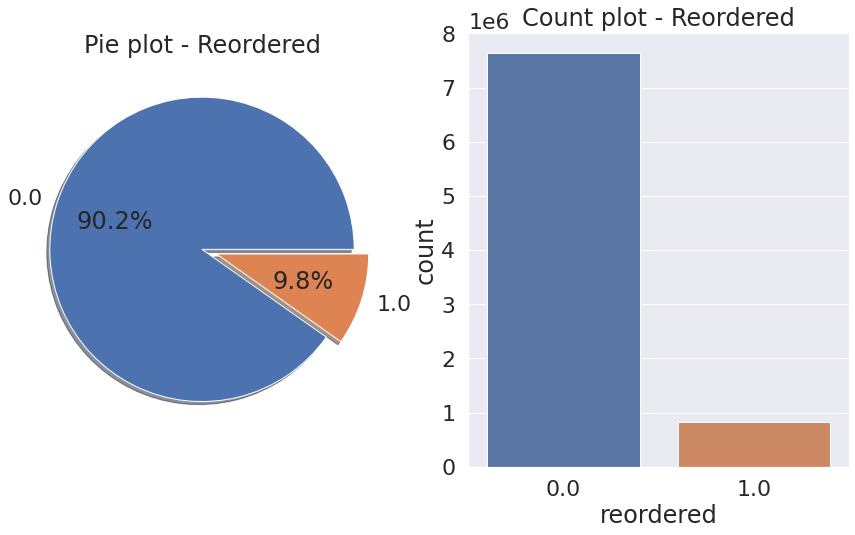

In [ ]:
# 타겟 레이블 분포 확인
f,ax =plt.subplots(1, 2, figsize=(15, 8))

y.value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Reordered')
ax[0].set_ylabel('')

sns.countplot(x='reordered', data=df, ax=ax[1])
ax[1].set_title('Count plot - Reordered')
plt.show()

* 따로 EDA 해보기

### 모델 생성 및 학습/예측/평가

In [ ]:
# 검증을 위한 매트릭스 함수

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

# 모델과 데이터를 받아서 학습/예측/평가하는 함수 정의
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimatiors=1000, num_leaves=64, n_jobs=1, boost_from_average=False)    
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

오차 행렬
[[1889802   21658]
 [ 168110   39096]]
정확도: 0.9104, 정밀도: 0.6435, 재현율: 0.1887, F1: 0.2918, AUC: 0.8354


In [ ]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

NameError: ignored

### feature importance

In [ ]:
fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, ax = ax)

## XGBoost Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

import xgboost as xgb
root = '/content/drive/MyDrive/instacart/instacart-market-basket-analysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,1.0,196,10.0,9.0,0.899902,1.400391,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
1,1.0,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
2,1.0,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,6.0
3,1.0,12427,10.0,9.0,0.899902,3.300781,19.562500,10.0,1.0,1.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
4,1.0,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,NaN,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0


In [ ]:
df.columns

Index(['user_id', 'product_id', 'user_product_reorder_percentage',
       'total_product_orders_by_user', 'total_product_reorders_by_user',
       'avg_add_to_cart_by_user', 'avg_days_since_last_bought',
       'last_ordered_in', 'order_-3', 'order_-2', 'order_-1', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered',
       'mean_add_to_cart_order', 'reorder_rate', 'total_orders',
       'total_reorders', 'unique_users', 'order_1st_total_cnt',
       'order_2nd_total_cnt', 'is_organic', 'order_2nd_rate',
       'aisle_mean_add_to_cart_order', 'aisle_std_add_to_cart_order',
       'aisle_reorder_percentage', 'aisle_total_orders',
       'aisle_total_reorders', 'aisle_unique_users', 'aisle_0', 'aisle_1',
       'aisle_2', 'aisle_3', 'aisle_4', 'aisle_5', 'aisle_6', 'aisle_7',
       'department_mean_add_to_cart_order', 'department_std_add_to_cart_order',
       'department_reorder_percentage', 'department_total_orders',
       'department_total_

In [ ]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [ ]:
df.head()

,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,order_-1,order_number,...,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,10.0,9.0,0.899902,1.400391,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,NaN,NaN,NaN,11.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,6.0
3,10.0,9.0,0.899902,3.300781,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,NaN,NaN,11.0,...,0.694824,0.706055,5.898438,0.666504,1.0,0.666504,6,6,9,1.0


In [ ]:
df.shape

(8474661, 68)

In [ ]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [ ]:
X = df[x_cols]
y = df[label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [ ]:
y_train.value_counts()

0.0    5734377
1.0     621618
Name: reordered, dtype: int64

In [ ]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [ ]:
y_test.value_counts()

0.0    1911460
1.0     207206
Name: reordered, dtype: int64

### XGBoost Model

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
xgb_params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "tree_method"      :"exact",
    "eta"              :0.1,
    "max_depth"        :6,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "alpha"            :2e-05,
    "scale_pos_weight" :10,
    "lambda"           :10
}

In [ ]:
watchlist= [(D_train, "train")]
model = xgb.train(params=xgb_params, dtrain=D_train, num_boost_round = 80, evals = watchlist, verbose_eval = 10)

[0]	train-logloss:0.665619
[10]	train-logloss:0.553871
[20]	train-logloss:0.533304
[30]	train-logloss:0.527607
[40]	train-logloss:0.524945
[50]	train-logloss:0.523517
[60]	train-logloss:0.52267
[70]	train-logloss:0.521913
[79]	train-logloss:0.521178


In [ ]:
probability = model.predict(D_test)

In [ ]:
predictions = [1 if i > 0.5 else 0 for i in probability]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.60      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.7423038836701963
F1 Score:  0.36842714097984414
Area under curve :  0.8342153530139002 



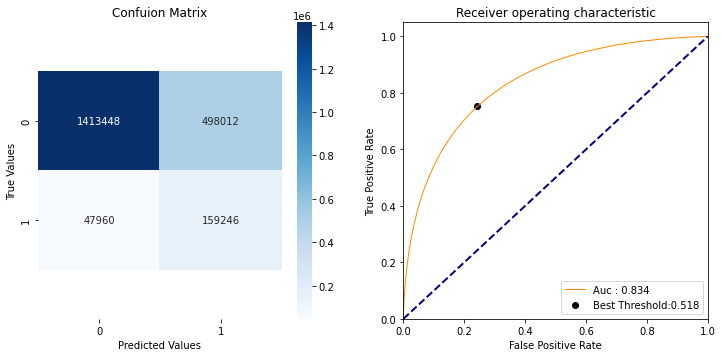

In [ ]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

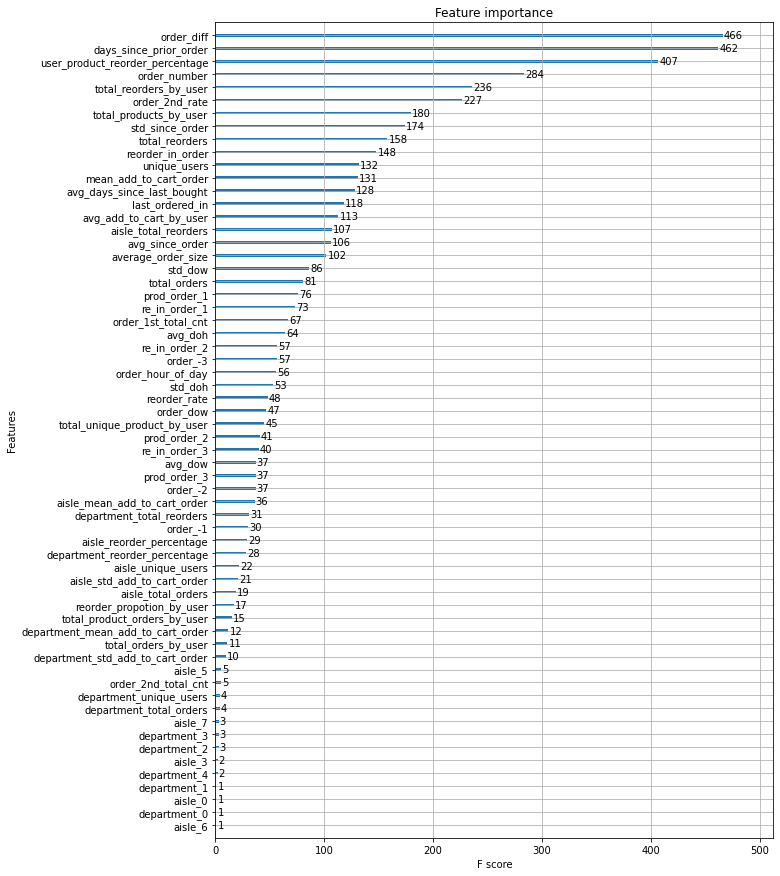

In [ ]:
fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, ax = ax)
fig.savefig('XGBoost Feature Importance Plot.png')

In [ ]:
submission = df[['order_id', 'products']]  ## 데이터프래임 생성
submission.reset_index(inplace=True)
submission = submission.sort_values(by ='order_id')
submission = submission.fillna('None')
submission.to_csv('submission.csv',index=False)

KeyError: ignored

##Catboost Classifier

GBM의 문제점 중 하나인 과적합 문제를 해결하고, 기존 GBM 계열 알고리즘인 XGBoost, LightGBM 알고리즘보다 학습 속도가 개선된 모델. XGBoost, LightGBM이 Hyper-parameter에 따라 성능이 달라지는 문제를 해결함. Symmetric Tree 구조를 사용한다.

In [ ]:
pip install catboost

     |████████████████████████████████| 76.6 MB 95 kB/s 


In [ ]:
from catboost import CatBoostClassifier

learning_rate = [0.001,0.01,0.1]
max_depth = [5,10]

#Loop for the Tuning
for lr in learning_rate:
    for n in max_depth:
        clf = CatBoostClassifier(learning_rate=lr,max_depth = n,task_type = "GPU",verbose = False)

        clf.fit(X_train,y_train)

        #y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        Y_pred = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        print(f'Train f1 score at learning rate {lr} and max_depth {n} is {f1_score(y_train, Y_pred)}')
        print(f'Test f1 score at learning rate {lr} and max_depth {n} is {f1_score(y_test, y_pred)}')
        print("-"*50)


Train f1 score at learning rate 0.001 and max_depth 5 is 0.23008333497507832
Test f1 score at learning rate 0.001 and max_depth 5 is 0.23144440112934286
--------------------------------------------------
Train f1 score at learning rate 0.001 and max_depth 10 is 0.2543150018820924
Test f1 score at learning rate 0.001 and max_depth 10 is 0.2542712483527662
--------------------------------------------------
Train f1 score at learning rate 0.01 and max_depth 5 is 0.27509482051223877
Test f1 score at learning rate 0.01 and max_depth 5 is 0.2754303007376584
--------------------------------------------------
Train f1 score at learning rate 0.01 and max_depth 10 is 0.287408168894015
Test f1 score at learning rate 0.01 and max_depth 10 is 0.2849942071289929
--------------------------------------------------
Train f1 score at learning rate 0.1 and max_depth 5 is 0.29594387228507546
Test f1 score at learning rate 0.1 and max_depth 5 is 0.29381093399174996
-----------------------------------------

In [ ]:
n_estimators = [100,500,1000]
class_weights = [{0:1,1:2},{0:1,1:4},{0:1,1:6}]

#Loop for the Tuning
for n in n_estimators:
    for l in class_weights:
        clf = CatBoostClassifier(learning_rate=0.1,max_depth = 10,n_estimators = n,class_weights = l,task_type = "GPU",verbose = False)
        clf.fit(X_train,y_train)

        #y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        Y_pred = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        print(f'Train f1 score at n_estimators {n} and class_weights {l} is {f1_score(y_train, Y_pred)}')
        print(f'Test f1 score at n_estimators {n} and  class_weights {l} is {f1_score(y_test, y_pred)}')
        print("-"*50)

Train f1 score at n_estimators 100 and class_weights {0: 1, 1: 2} is 0.41246806985910284
Test f1 score at n_estimators 100 and  class_weights {0: 1, 1: 2} is 0.40780587176563865
--------------------------------------------------
Train f1 score at n_estimators 100 and class_weights {0: 1, 1: 4} is 0.44498942078460507
Test f1 score at n_estimators 100 and  class_weights {0: 1, 1: 4} is 0.4415990081673235
--------------------------------------------------
Train f1 score at n_estimators 100 and class_weights {0: 1, 1: 6} is 0.42255856522296503
Test f1 score at n_estimators 100 and  class_weights {0: 1, 1: 6} is 0.4193683122156041
--------------------------------------------------
Train f1 score at n_estimators 500 and class_weights {0: 1, 1: 2} is 0.43926808819589097
Test f1 score at n_estimators 500 and  class_weights {0: 1, 1: 2} is 0.4178026432023279
--------------------------------------------------
Train f1 score at n_estimators 500 and class_weights {0: 1, 1: 4} is 0.4668603551255371

In [ ]:
clf = CatBoostClassifier(learning_rate=0.1,max_depth = 10,n_estimators = 100,class_weights ={0: 1, 1: 4},task_type = "GPU",verbose = False)
clf.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,clf.predict(X_train)))
print('Test f1 score',f1_score(y_test,clf.predict(X_test)))

Train f1 score 0.4449897191142683
Test f1 score 0.44159989695224183


In [ ]:
from sklearn.metrics import confusion_matrix

print('Train confusion_matrix')
plot_confusion_matrix(y_train,clf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(y_test,clf.predict(X_test))

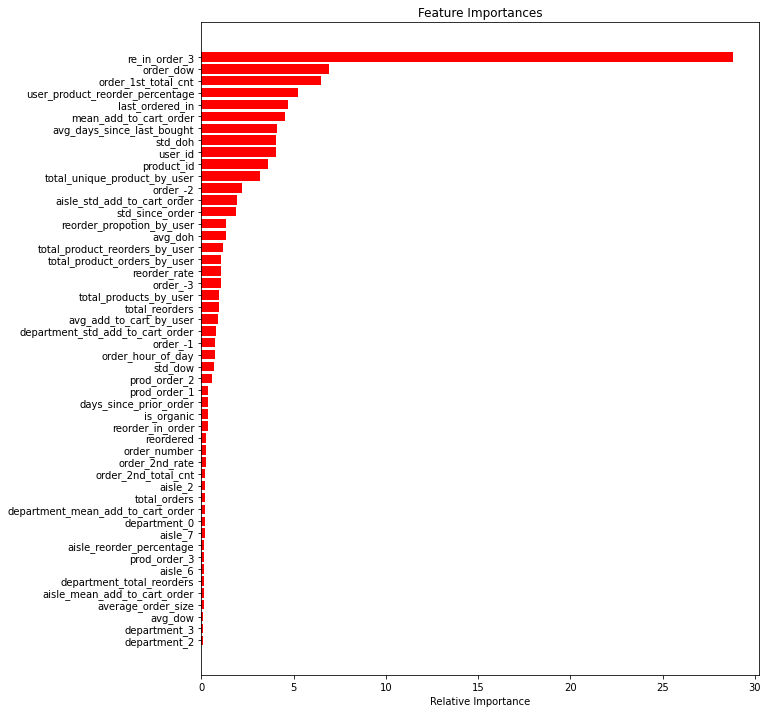

In [ ]:
# 피처 중요도
features = df.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-50:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# save the model to disk
import pickle
filename = 'catboost_model.sav'
pickle.dump(clf, open(filename, 'wb'))